# Reinforement Learning - TicTacToe

Planning out idea and learning new technique 

In [2]:
import numpy as np
from typing import Tuple, List

In [3]:
p1_wins = 0
p2_wins = 0
draws = 0
results = []
n=[]
winsCol = np.zeros(3)
winsRow = np.zeros(3)
alpha = []
beta=[]

In [4]:
class Board(object):
    def __init__(self, p1, p2) -> None:
        '''
        This constructor init the empty board and two players
        '''
        self.p1 = p1
        self.p2 = p2
        self.board = np.zeros((BOARD_ROW, BOARD_COL))
        
        self.gameLoop = True
    
    def winningCondition(self) -> int: 
        '''
        winningCondition is implemented to check any winning condition
        Function return the player Id which is either 1 or -1 
        the checker function is called after each iteration of the player step
        '''
        for i in range(BOARD_COL-1):
            col: np.ndarray = self.board[i, :]
            
            if sum(col) == 3:
                self.gameLoop = False
                winsCol[i] += 1
                return 1
            if sum(col) == -3:
                self.gameLoop = False
                winsCol[i] += 1
                return -1
            row: np.ndarray = self.board[:, i]
            
            if sum(row) == 3:
                self.gameLoop = False
                winsRow[i] += 1
                return 1
            if sum(row) == -3:
                self.gameLoop = False
                winsRow[i] += 1
                return -1
            
        # this are diagonal check 
        diagonal_one: int = sum(np.diag(self.board))
        diagonal_two: int = sum(np.diag(np.fliplr(self.board)))
        
        diagonal:int = max(abs(diagonal_one), abs(diagonal_two))
        if diagonal == 3:
            self.gameLoop = False
            if (diagonal_one == 3) | (diagonal_two == 3):
                return 1
            else:
                return -1
            
        #Checking for Tie Condition
        emptyPosition: list = self.emptySpace()
        if (len(emptyPosition)) == 0:
            self.gameLoop = False
            return 0

        self.gameLoop = True
        return 2

    def updateBox(self, position:Tuple[int, int], playerSymbol:int) -> None:
        """
        Update the position of the box
        """
        if self.board[position] == 0:
            self.board[position] = playerSymbol
        else:
            print("Place already occupied")
        

    def emptySpace(self) -> List[Tuple[int, int]]:
        '''
        Checks for aviable space in the board
        '''
        space = []
        for i in range(BOARD_ROW):
            for j in range(BOARD_COL):
                if self.board[i, j] == 0:
                    space.append((i, j))
        return space


    def render(self) -> None:
        """
        Function renders the board in the terminal,
        Will Update to pygame later
        """
        for i in range(BOARD_ROW):
            print("--------------")
            border = "|  "
            for j in range(BOARD_COL):
                if self.board[i][j] == 0:
                    border += "  | "
                if self.board[i][j] == 1:
                    border += "X | "
                if self.board[i][j] == -1:
                    border += "0 | "
            print(border)
        print("--------------")

# Player Class 
### Defines the player action such move taken and the influence in the movement

Player implements Thompsom Sampling algorithms to choose the action, \
Action exploration and exploting will be manage 

In [9]:
class Player(object):
    def __init__(self, name: str, actionSize: int, symbol:int) -> None:
        '''
        Player Class define player behaviour and actions

        Name : String = Which Store either player is computer or human
        actionSize : Int [Array Size] = Size of the board and move that can be made
        alpha : ndarray = Prior Successes stored in the array
        beta : ndarray = Failures are stored in the array
        
        n: ndarray = count of the action selected
        '''

        self.alpha: np.ndarray = np.ones(actionSize)
        self.beta: np.ndarray = np.ones(actionSize)
        self.n : np.ndarray = np.zeros(actionSize)
        self.playerSymbol: int = symbol
        self.name: str = name

    def chooseAction(self, avaiable_positions: List[Tuple[int, int]]) -> Tuple[int, int]:
        sampled_values = np.zeros(len(self.alpha))
    
        availableSpace = []
        for pos in avaiable_positions:
            availableSpace.append(self.actionIndex(pos))

        for i in availableSpace:
            sampled_values[i] = np.random.beta(self.alpha[i], self.beta[i])

        actionIndex = np.argmax(sampled_values)
        action = self.indexAction(actionIndex)
    
        self.n[actionIndex] += 1 
        return action

    def actionIndex(self, action):
        return action[0] * 3 + action[1]

    def indexAction(self, index):
        return divmod(index, 3)

    def rewardAgent(self, action: Tuple[int, int], reward: int):
        actionIndex = self.actionIndex(action)
        if reward == 1:
            self.alpha[actionIndex] += 1
        else:
            self.beta[actionIndex] += 1
        self.n[actionIndex] += 1


        

In [11]:
BOARD_ROW = 3
BOARD_COL = 3

In [13]:
p1 = Player("Player 1", actionSize=BOARD_ROW * BOARD_COL, symbol=1)
p2 = Player("Player 2", actionSize=BOARD_ROW * BOARD_COL, symbol=-1)

In [15]:
for i in range(50000):
    game = Board(p1, p2)
    currentPlayer = game.p1
    opponent = game.p2
    while game.gameLoop:
        availableSpace: List[Tuple[int, int]] = game.emptySpace()
        if len(availableSpace) <= 0:
            print("It's a tie")
            game.p1.rewardAgent((-1, -1), 0)
            game.p2.rewardAgent((-1, -1), 0)
            game.gameLoop = False
            break
        action: Tuple[int, int] = currentPlayer.chooseAction(availableSpace)
        if action not in availableSpace:
            print(f"Invalid action taken: {action}. Try again")
            continue
        if action in availableSpace:
            game.updateBox(action, currentPlayer.playerSymbol)
            game.render()
            checkWinners: int = game.winningCondition()
            if checkWinners != 2:
                if checkWinners == 1:
                    print("Player 1 Wins")
                    game.p1.rewardAgent(action, checkWinners)
                    game.p2.rewardAgent(action, -checkWinners)
                    p1_wins += 1
                    results.append(1)
                elif checkWinners == -1:
                    print("PPlayer 2 Wins")
                    game.p1.rewardAgent(action, checkWinners)
                    game.p2.rewardAgent(action, -checkWinners)
                    p2_wins += 1
                    results.append(-1)
                elif checkWinners == 0:
                    print("It's a tie")
                    game.p1.rewardAgent(action, checkWinners)
                    game.p2.rewardAgent(action, -checkWinners)
                    draws += 1
                    results.append(0)
                game.gameLoop = False
                break
            currentPlayer, opponent = opponent, currentPlayer
        else:
            print("Invalid action taken, Try again")
        alpha.append(p1.alpha)
        beta.append(p1.beta)

--------------
|  X |   |   | 
--------------
|    |   |   | 
--------------
|    |   |   | 
--------------
--------------
|  X |   |   | 
--------------
|  0 |   |   | 
--------------
|    |   |   | 
--------------
--------------
|  X |   |   | 
--------------
|  0 | X |   | 
--------------
|    |   |   | 
--------------
--------------
|  X |   |   | 
--------------
|  0 | X |   | 
--------------
|    | 0 |   | 
--------------
--------------
|  X | X |   | 
--------------
|  0 | X |   | 
--------------
|    | 0 |   | 
--------------
--------------
|  X | X |   | 
--------------
|  0 | X |   | 
--------------
|    | 0 | 0 | 
--------------
--------------
|  X | X |   | 
--------------
|  0 | X |   | 
--------------
|  X | 0 | 0 | 
--------------
--------------
|  X | X |   | 
--------------
|  0 | X | 0 | 
--------------
|  X | 0 | 0 | 
--------------
--------------
|  X | X | X | 
--------------
|  0 | X | 0 | 
--------------
|  X | 0 | 0 | 
--------------
Player 1 Wins
--------------

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
n

[]

In [17]:
p1.n

array([7.3085e+04, 6.6746e+04, 5.9448e+04, 1.2800e+02, 1.2400e+02,
       1.1800e+02, 6.0000e+00, 2.1200e+02, 2.2000e+02])

In [18]:
import matplotlib.pyplot as plt

# Ploting the result and Calculation
Result display One sided response such as Same movement, Same Player Winner more exploitation and no exploration

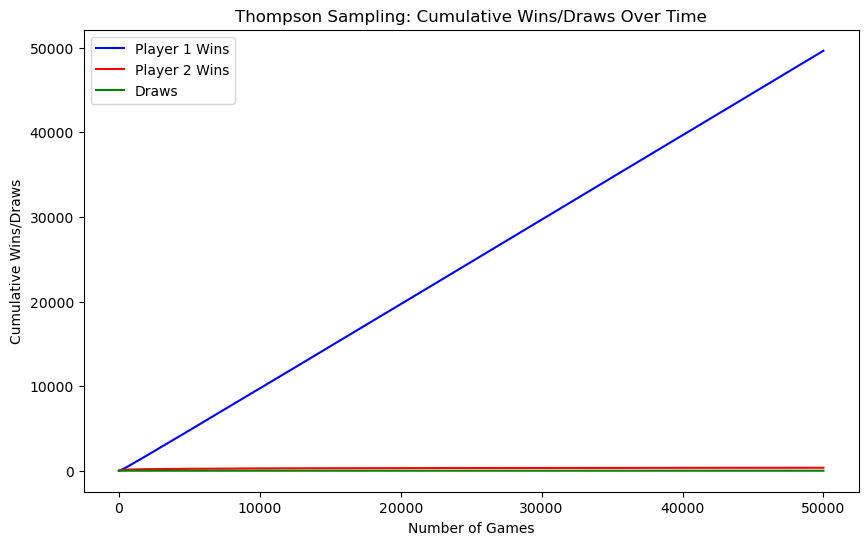

In [20]:
games = len(results)
p1_wins = []
p2_wins = []
draws = []

p1_win_count = 0
p2_win_count = 0
draw_count = 0

for i in range(games):
    if results[i] == 1:
        p1_win_count += 1
    elif results[i] == -1:
        p2_win_count += 1
    else:
        draw_count += 1
    
    # Append cumulative counts at each step
    p1_wins.append(p1_win_count)
    p2_wins.append(p2_win_count)
    draws.append(draw_count)
plt.figure(figsize=(10, 6))
plt.plot(p1_wins, label="Player 1 Wins", color="blue")
plt.plot(p2_wins, label="Player 2 Wins", color="red")
plt.plot(draws, label="Draws", color="green")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Wins/Draws")
plt.title("Thompson Sampling: Cumulative Wins/Draws Over Time")
plt.legend()
plt.show()

In [21]:
p2_win_count

350

In [22]:
winsCol

array([49647.,   345.,     0.])

In [23]:
winsRow

array([4., 1., 0.])

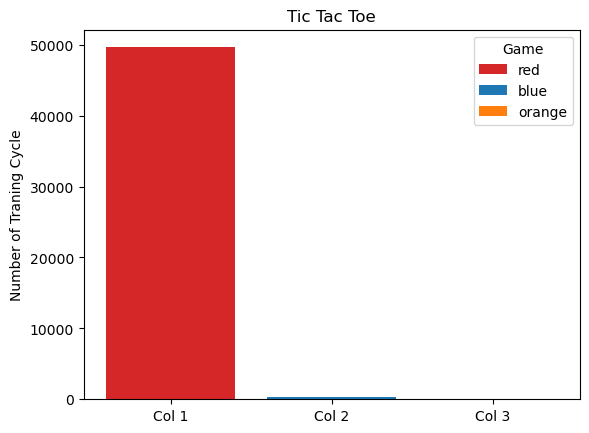

In [32]:
fig, ax = plt.subplots()
label = ["Col 1", "Col 2", "Col 3"]
color = ['tab:red', 'tab:blue' , 'tab:orange']

bar_labels = ['red', 'blue', 'orange']
ax.bar(label, winsCol, label=bar_labels, color=color)
ax.set_ylabel('Number of Traning Cycle')
ax.set_title('Tic Tac Toe')
ax.legend(title='Game')

plt.show()

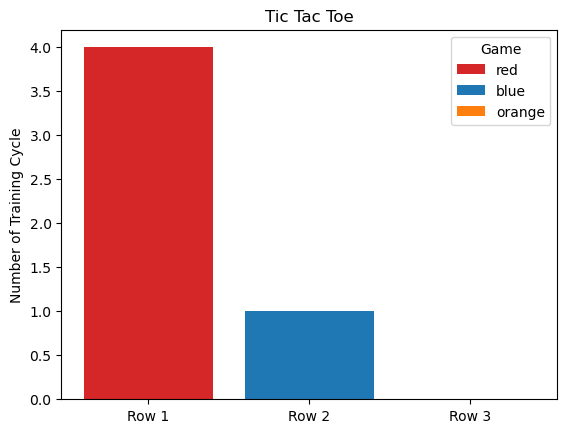

In [34]:
fig, ax = plt.subplots()
label = ["Row 1", "Row 2", "Row 3"]
color = ['tab:red', 'tab:blue' , 'tab:orange']

bar_labels = ['red', 'blue', 'orange']
ax.bar(label, winsRow, label=bar_labels, color=color)
ax.set_ylabel('Number of Training Cycle')
ax.set_title('Tic Tac Toe')
ax.legend(title='Game')

plt.show()